# Quantification

In [56]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

# import our modules
from news import fetch_news_headline
from profit import calc_profit

## Load Data

In [57]:
stocks: pd.DataFrame = pd.read_csv("../../data/stocks.csv", index_col=0, parse_dates=True)
company = "TSLA"
stock = stocks.query(f"Company == '{company}'").drop(columns=["Company", "Sector"])
stock

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-02,20.008667,20.579332,19.508667,19.950666,296871000
2017-11-03,19.966667,20.416668,19.675333,20.406000,133410000
2017-11-06,20.466667,20.500000,19.934000,20.185333,97290000
2017-11-07,20.068001,20.433332,20.002001,20.403334,79414500
2017-11-08,20.366667,20.459333,20.086666,20.292667,70879500
...,...,...,...,...,...
2022-10-26,219.399994,230.600006,218.199997,224.639999,85012500
2022-10-27,229.770004,233.809998,222.850006,225.089996,61638800
2022-10-28,225.399994,228.860001,216.350006,228.520004,69152400


## Combine Stocks and News

Intuitively, the news information can only provide us with very vague information about the stock price. In fact, it is already good enough if today's news can tell us whether the stock price will increase tomorrow.

In [58]:
# shifted percentage change: (tomorrow - today) / today
df = stock[["Close"]].pct_change().shift(-1).dropna()

# whether the stock price will increase compared with today's price
df = df > 0
df.rename(columns={"Close": "Will Go Up?"}, inplace=True)
df

,Will Go Up?
Date,
2017-11-02,True
2017-11-03,False
2017-11-06,True
2017-11-07,False
2017-11-08,False
...,...
2022-10-25,True
2022-10-26,True
2022-10-27,True


Now, we attach the news headline on each date to the data frame:

In [59]:
DATABASE_FILEPATH = "../../data/news.db"

df["Headline"] = np.nan

for date in df.index:
    # correct date format
    date_str = datetime.strftime(date, "%Y-%m-%d")
    
    # fetch news headline from database
    headline = fetch_news_headline(DATABASE_FILEPATH, company, date_str)
    
    # attch news headline to data frame
    df.loc[date, "Headline"] = headline

df = df[["Headline", "Will Go Up?"]].dropna()
df

,Headline,Will Go Up?
Date,,
2017-11-02,"Okay Elon Musk, what's gone wrong with the Tes...",True
2017-11-03,Tesla hits bumps in pursuit of mass market,False
2017-11-06,Tesla Investors May Be Losing Patience,True
2017-11-07,Bloomberg,False
2017-11-08,Elon Musk met with Erdogan to discuss Tesla's ...,False
...,...,...
2022-10-25,Update: Tesla Cuts Prices in China After Signs...,True
2022-10-26,Exclusive: Tesla faces U.S. criminal probe ove...,True
2022-10-27,"From Tesla to SpaceX, what Elon Musk touches t...",True


Split training and test data sets:

In [60]:
num_days_left_out = 90
train_df = df[:-num_days_left_out]
test_df = df[-num_days_left_out:]

## Word Embedding

Our goal is to predict whether the stock price will go up tomorrow based on today's news. So, it can be treated as a **classification** problem, more precisely, a **binary classification** problem. That is, we want to find a mapping / decision rule:

$$
\text{News Headline (Text)} \mapsto \{\text{True}, \text{False}\}
$$

But the headlines consist of text data. Hence, we need to first transform or encode them to numerical data. This procedure is called **word embedding**.

Usually, we need to train an additional model for word embedding, which is quite troublesome. To reduce our workload, fortunately, there is a pretrained model prodived by the module `sentence_transformers` that is ready to use.

In [61]:
from sentence_transformers import SentenceTransformer

```{seealso}
Check the [document](https://www.sbert.net/#) of sentence_transformers for more information.
```

Encode the news headlines with the model `SentenceTransformer`:

In [62]:
# load pretrained model
headline_encoder = SentenceTransformer("all-MiniLM-L6-v2")

# encode news headlines to NumPy arrays
embeddings = headline_encoder.encode(train_df["Headline"].tolist())

print(f"embeddings.shape: {embeddings.shape}")
embeddings

embeddings.shape: (978, 384)


array([[-0.00946767,  0.01169717,  0.07283923, ..., -0.07292849,
        -0.02329506,  0.11975066],
       [-0.01846967, -0.02873902,  0.03534317, ..., -0.13485262,
         0.01329796,  0.13287042],
       [ 0.02563943, -0.04956274,  0.04786101, ..., -0.07707552,
        -0.05291679,  0.0715071 ],
       ...,
       [-0.00674385,  0.0027471 ,  0.09396511, ..., -0.09142395,
         0.01973804,  0.08486167],
       [-0.07479677,  0.01877449,  0.07296403, ..., -0.08446505,
         0.02360164,  0.05853827],
       [ 0.01585246,  0.05186599,  0.07435998, ..., -0.07771911,
         0.01394665,  0.05791727]], dtype=float32)

As we can see, each headline is transformed to an array with length 384.

## Binary Classification Problem using SVM

As mentioned, we want to solve a classification problem.

In terms of machine learning terminologies, each sample $(\mathbf{x}, y)$ consists of a vector $\mathbf{x}$ representing 384 features (encoded news headline) and a binary label $y \in \{\text{True}, \text{False}\}$.

The most popular choice is the Support Vector Machine (SVM).

In [63]:
from sklearn.svm import SVC

# prepare training data
X_train = embeddings
y_train = train_df["Will Go Up?"].to_numpy()

# train!
clf = SVC(C=1, kernel="rbf")
clf.fit(X_train, y_train)

SVC(C=1)

Prepare the test data follows exactly the same procedure as before:

In [64]:
X_test = headline_encoder.encode(test_df["Headline"].tolist())
y_test = test_df["Will Go Up?"].to_numpy()

Predict the whether price will go up or down:

In [65]:
y_pred = clf.predict(X_test)

ROC curve and AUC score:

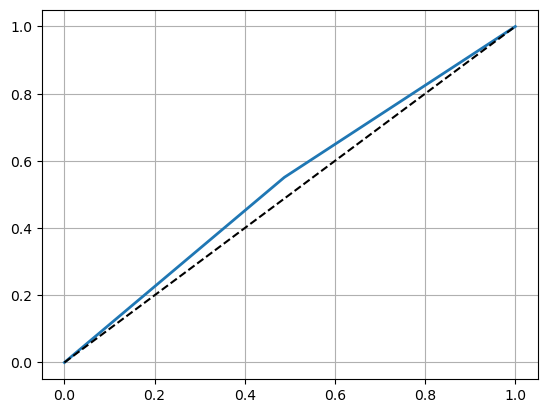

In [66]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, linewidth=2) 
plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.grid()
plt.show()

In [67]:
roc_auc_score(y_test, y_pred)

0.5316077650572424

Unfortunately, the value of AUC is only *slightly* grater than 0.5, which means the classifier not very satisfactory.

## Profit

Decide the dates to buy and sell:

In [68]:
# Find buying and selling dates
buy_dates = []
sell_dates = []
is_holding_shares = False
for i, date in enumerate(test_df.index):
    will_go_up = y_pred[i]
    if is_holding_shares:
        # price will go down, sell it!
        if not will_go_up:
            sell_dates.append(date)
            is_holding_shares = False
    else:
        # price will go up, buy!
        if will_go_up:
            buy_dates.append(date)
            is_holding_shares = True

# convert to Pandas `DatetimeIndex`
buy_dates = pd.DatetimeIndex(buy_dates)
sell_dates = pd.DatetimeIndex(sell_dates)

buy_dates, sell_dates

(DatetimeIndex(['2022-06-27', '2022-07-05', '2022-07-07', '2022-07-12',
                '2022-07-14', '2022-07-19', '2022-07-26', '2022-08-01',
                '2022-08-05', '2022-08-11', '2022-09-01', '2022-09-12',
                '2022-09-14', '2022-09-20', '2022-09-26', '2022-09-29',
                '2022-10-07', '2022-10-11', '2022-10-25'],
               dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2022-07-01', '2022-07-06', '2022-07-11', '2022-07-13',
                '2022-07-15', '2022-07-21', '2022-07-27', '2022-08-04',
                '2022-08-09', '2022-08-23', '2022-09-08', '2022-09-13',
                '2022-09-19', '2022-09-22', '2022-09-27', '2022-10-03',
                '2022-10-10', '2022-10-19', '2022-10-27'],
               dtype='datetime64[ns]', freq=None))

How much can we earn if the strategy is entirely news-driven?

In [69]:
start_date = test_df.index[0]
profit_rate = calc_profit(stock, buy_dates, sell_dates, start_date)
print(f"Profit rate: {profit_rate:.2%}")

Profit rate: 3.25%


The profit rate is only 3.25%, which lower than both SMA and prediction-based (LSTM) strategies.

## Conclusion

As we can see, it is not adequate to predict whether the stock price will go up or down tomorrow *only* based on the news. More delicate techniques are required in future works!